In [6]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

from xgboost import plot_importance
import matplotlib.pyplot as plt

from utils.snowflake_connector import SnowflakeConnector

import mlflow

In [7]:
person_df = pd.read_csv( r"C:\Users\User\Downloads\pums\psam_p05.csv")
housing_df = pd.read_csv( r"C:\Users\User\Downloads\pums\psam_h05.csv")

In [16]:
query = """
WITH person_agg AS (
  SELECT
    SERIALNO,
    SUM(PWGTP) AS total_person_weight,
    SUM(PWGTP * AGEP) / NULLIF(SUM(PWGTP), 0) AS weighted_avg_age,
    SUM(CASE WHEN SEX = 2 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_female,
    SUM(CASE WHEN ESR IN (1, 2) THEN PWGTP ELSE 0 END) AS estimated_num_workers,
    SUM(PWGTP * INTP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_INTP,
    SUM(PWGTP * OIP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_OIP,
    SUM(PWGTP * PAP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_PAP,
    SUM(PWGTP * PERNP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_PERNP,
    SUM(PWGTP * PINCP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_PINCP,
    SUM(PWGTP * RETP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_RETP,
    SUM(PWGTP * SEMP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_SEMP,
    SUM(PWGTP * SSIP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_SSIP,
    SUM(PWGTP * SSP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_SSP,
    SUM(PWGTP * WAGP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_WAGP,
    SUM(PWGTP * PINCP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) / NULLIF(COUNT(*), 0) AS income_per_person,
    SUM(CASE WHEN DIS = 1 THEN PWGTP ELSE 0 END) AS num_disabled,
    SUM(CASE WHEN HICOV = 1 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_insured,
    SUM(CASE WHEN HINS4 = 1 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_medicaid,
    SUM(PWGTP * POVPIP) / NULLIF(SUM(PWGTP), 0) AS avg_poverty_ratio,
    SUM(CASE WHEN RACSOR = 1 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_other_race
  FROM public.psam_p05
  GROUP BY SERIALNO
)

SELECT
  h.*,
  h.ELEP * h.ADJHSG / 1000000.0 AS adj_ELEP,
  h.FULP * h.ADJHSG / 1000000.0 AS adj_FULP,
  h.GASP * h.ADJHSG / 1000000.0 AS adj_GASP,
  h.INSP * h.ADJHSG / 1000000.0 AS adj_INSP,
  h.MHP * h.ADJHSG / 1000000.0 AS adj_MHP,
  h.MRGP * h.ADJHSG / 1000000.0 AS adj_MRGP,
  h.RNTP * h.ADJHSG / 1000000.0 AS adj_RNTP,
  h.SMP * h.ADJHSG / 1000000.0 AS adj_SMP,
  h.SMOCP * h.ADJHSG / 1000000.0 AS adj_SMOCP,
  h.TAXAMT * h.ADJHSG / 1000000.0 AS adj_TAXAMT,
  h.VALP * h.ADJHSG / 1000000.0 AS adj_VALP,
  h.WATP * h.ADJHSG / 1000000.0 AS adj_WATP,
  h.HINCP / NULLIF(h.NP, 0) AS income_per_person_household,
  h.HINCP / NULLIF(h.RMSP, 0) AS income_per_room,
  h.RNTP / NULLIF(h.HINCP, 0) AS rent_to_income_ratio,
  h.HHLDRAGEP * h.HINCP AS age_x_income,
  p.*
FROM public.psam_h05 h
LEFT JOIN person_agg p ON h.SERIALNO = p.SERIALNO
WHERE h.TYPEHUGQ = '1' AND h.FS IN (1, 2)
"""
sf = SnowflakeConnector()
df = sf.query(query)

✅ Connected to Snowflake


C:\Users\User\PycharmProjects\pums\utils\snowflake_connector.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.ctx)


✅ Query executed: 12215 rows retrieved


In [18]:
dupes = df.columns[df.columns.duplicated()]
print(dupes)


Index(['SERIALNO'], dtype='object')


In [12]:
sf = SnowflakeConnector()
df = sf.query(
"""
WITH person_agg AS (
  SELECT
    SERIALNO,
    SUM(PWGTP) AS total_person_weight,
    SUM(PWGTP * AGEP) / NULLIF(SUM(PWGTP), 0) AS weighted_avg_age,
    SUM(CASE WHEN SEX = 2 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_female,
    SUM(CASE WHEN ESR IN (1, 2) THEN PWGTP ELSE 0 END) AS estimated_num_workers,
    -- Adjusted income fields
    SUM(PWGTP * INTP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_INTP,
    SUM(PWGTP * OIP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_OIP,
    SUM(PWGTP * PAP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_PAP,
    SUM(PWGTP * PERNP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_PERNP,
    SUM(PWGTP * PINCP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_PINCP,
    SUM(PWGTP * RETP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_RETP,
    SUM(PWGTP * SEMP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_SEMP,
    SUM(PWGTP * SSIP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_SSIP,
    SUM(PWGTP * SSP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_SSP,
    SUM(PWGTP * WAGP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) AS adj_avg_WAGP,
    -- Derived per-person income
    SUM(PWGTP * PINCP * ADJINC / 1000000.0) / NULLIF(SUM(PWGTP), 0) / NULLIF(COUNT(*), 0) AS income_per_person,
    SUM(CASE WHEN DIS = 1 THEN PWGTP ELSE 0 END) AS num_disabled,
    SUM(CASE WHEN HICOV = 1 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_insured,
    SUM(CASE WHEN HINS4 = 1 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_medicaid,
    SUM(PWGTP * POVPIP) / NULLIF(SUM(PWGTP), 0) AS avg_poverty_ratio,
    SUM(CASE WHEN RACSOR = 1 THEN PWGTP ELSE 0 END) / NULLIF(SUM(PWGTP), 0) AS prop_other_race
  FROM public.psam_p06
  GROUP BY SERIALNO
)

SELECT
  h.*,

  -- Adjusted housing cost fields
  h.ELEP * h.ADJHSG / 1000000.0 AS adj_ELEP,
  h.FULP * h.ADJHSG / 1000000.0 AS adj_FULP,
  h.GASP * h.ADJHSG / 1000000.0 AS adj_GASP,
  h.INSP * h.ADJHSG / 1000000.0 AS adj_INSP,
  h.MHP * h.ADJHSG / 1000000.0 AS adj_MHP,
  h.MRGP * h.ADJHSG / 1000000.0 AS adj_MRGP,
  h.RNTP * h.ADJHSG / 1000000.0 AS adj_RNTP,
  h.SMP * h.ADJHSG / 1000000.0 AS adj_SMP,
  h.SMOCP * h.ADJHSG / 1000000.0 AS adj_SMOCP,
  h.TAXAMT * h.ADJHSG / 1000000.0 AS adj_TAXAMT,
  h.VALP * h.ADJHSG / 1000000.0 AS adj_VALP,
  h.WATP * h.ADJHSG / 1000000.0 AS adj_WATP,

  -- Derived ratios
  h.HINCP / NULLIF(h.NP, 0) AS income_per_person_household,
  h.HINCP / NULLIF(h.RMSP, 0) AS income_per_room,
  h.RNTP / NULLIF(h.HINCP, 0) AS rent_to_income_ratio,
  h.HHLDRAGEP * h.HINCP AS age_x_income,

  -- Person-level aggregates
  p.total_person_weight,
  p.weighted_avg_age,
  p.prop_female,
  p.estimated_num_workers,
  p.income_per_person,
  p.num_disabled,
  p.prop_insured,
  p.prop_medicaid,
  p.avg_poverty_ratio,
  p.prop_other_race,
  p.adj_avg_INTP,
  p.adj_avg_OIP,
  p.adj_avg_PAP,
  p.adj_avg_PERNP,
  p.adj_avg_PINCP,
  p.adj_avg_RETP,
  p.adj_avg_SEMP,
  p.adj_avg_SSIP,
  p.adj_avg_SSP,
  p.adj_avg_WAGP

FROM public.psam_h06 h
LEFT JOIN person_agg p ON h.SERIALNO = p.SERIALNO
WHERE h.FS IN (1, 2)
"""
)

✅ Connected to Snowflake


C:\Users\User\PycharmProjects\pums\utils\snowflake_connector.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.ctx)


✅ Query executed: 153864 rows retrieved


In [13]:
df = df[~df['FS'].isna()]
df = df.reset_index(drop=True)
df["FS"] = df["FS"].map({1: 1, 2: 0})

In [30]:
WORKING_DIR = r"C:\Users\User\PycharmProjects\pums\working_dir"
INPUT_FILE = "snap_model_input.parquet"

df = pd.read_parquet(os.path.join(WORKING_DIR, INPUT_FILE))
df.FS.unique()

array([nan,  1.])

In [28]:
WORKING_DIR = r"C:\Users\User\PycharmProjects\pums\working_dir"
INPUT_FILE = "snap_model_input.parquet"

df = pd.read_parquet(os.path.join(WORKING_DIR, INPUT_FILE))

# Exclude non-feature columns
exclusions = ["ELEP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", "SMOCP", "TAXAMT", "VALP", "WATP"] + \
             ['FS', 'RT', 'SERIALNO', 'NAICSP', 'SOCP', 'ADJINC', 'ADJHSG', 'WGTP', 'PWGTP'] + \
             ['WGTP' + str(i) for i in range(81)] + ['PWGTP' + str(i) for i in range(81)] + \
             ['VACS', 'VACDUR', 'VACOTH']
features = [col for col in df.columns if col not in exclusions]

# Prepare data
X = df[features]
X = X.astype({col: 'float64' for col in X.select_dtypes(include='int').columns})
y = df["FS"]
weight = df['WGTP']
X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.1, random_state=42
)

# Define pipeline with scaler and XGB
model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    ))
])

# Fit with sample weight (note: only XGBoost step gets sample_weight)
model.fit(X_train, y_train, xgb__sample_weight=weight_train)

y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred_default, sample_weight=weight_test))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94  104415.0
           1       0.50      0.29      0.36   12087.0

    accuracy                           0.90  116502.0
   macro avg       0.71      0.63      0.65  116502.0
weighted avg       0.88      0.90      0.88  116502.0



## Further feature engineering

In [14]:
alloc_cols = [
    col for col in df.columns
    if col.startswith("F") and col.endswith("P") and col not in ['FULFP', 'FULP', 'FINCP']
]
df["num_imputed_features"] = df[alloc_cols].eq(1).sum(axis=1)

In [15]:
def map_cplt(val):
    if val in [1, 2]:
        return "Spouse_Household"
    elif val in [3, 4]:
        return "Partner_Household"
    else:
        return "Not_Couple"

df["CPLT_group"] = df["CPLT"].replace("b", np.nan).astype(float).apply(map_cplt)


def map_wkexrel(val):
    if val in [1, 2, 4, 5]:
        return "Both_Worked"
    elif val in [3, 6]:
        return "Householder_Worked_Only"
    elif val in [7, 8]:
        return "Spouse_Worked_Only"
    elif val == 9:
        return "Neither_Worked"
    elif val in [10, 13]:
        return "Householder_Alone_FT"
    elif val in [11, 14]:
        return "Householder_Alone_Part"
    elif val in [12, 15]:
        return "Householder_Alone_None"
    else:
        return "No_Family"


df["WKEXREL_group"] = df["WKEXREL"].replace("bb", np.nan).apply(map_wkexrel)

df = pd.get_dummies(df, columns=["CPLT_group", "WKEXREL_group"], dtype=int)

df.drop(columns=["CPLT", "WKEXREL"], inplace=True)

In [54]:
exclusions =  ["ELEP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", "SMOCP", "TAXAMT", "VALP", "WATP"] + \
['FS', 'RT', 'SERIALNO', 'NAICSP', 'SOCP', 'ADJINC', 'ADJHSG', 'WGTP', 'PWGTP'] + \
['WGTP' + str(i) for i in range(81)] + ['PWGTP' + str(i) for i in range(81)] + \
['VACS', 'VACDUR', 'VACOTH']

features = [col for col in df.columns if col not in exclusions]

X = df[features]
X = X.astype({col: 'float64' for col in X.select_dtypes(include='int').columns})
y = df["FS"]
weight = df['WGTP']


X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.1, random_state=42
)

# --------------------
# Train model
# --------------------
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=weight_train)

# --------------------
# Evaluate
# --------------------
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, sample_weight=weight_test))

2025/05/09 10:26:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '82cc8b6104274841b09b8eedadd0a4a7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/05/09 10:26:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [10:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."


              precision    recall  f1-score   support

           0       0.92      0.97      0.95  102413.0
           1       0.61      0.36      0.45   13152.0

    accuracy                           0.90  115565.0
   macro avg       0.77      0.66      0.70  115565.0
weighted avg       0.89      0.90      0.89  115565.0



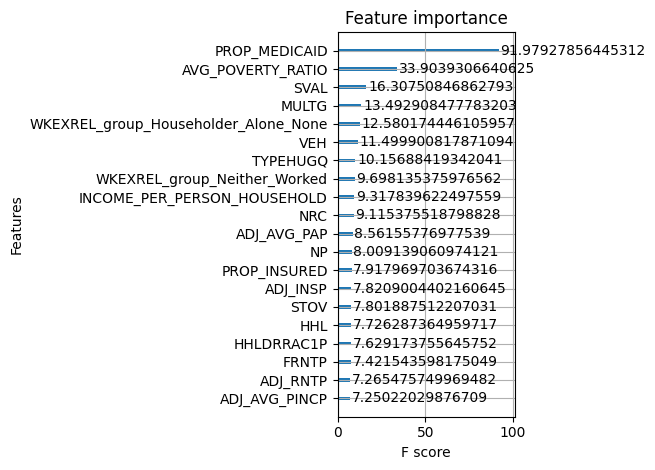

In [57]:
plot_importance(model, max_num_features=20, importance_type='gain')
plt.tight_layout()
plt.show()

In [61]:
import json
import mlflow
import mlflow.xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np
import os

# Set experiment (creates if it doesn't exist)
mlflow.set_experiment("food_stamp_prediction_v2")

# Turn on autologging for XGBoost
mlflow.xgboost.autolog()

# Start run
with mlflow.start_run(run_name="xgb_weighted_fs_model_v2") as run:
    run_id = run.info.run_id
    experiment = mlflow.get_experiment_by_name("food_stamp_prediction_v2")
    
    # Exclude non-feature columns
    exclusions =  ["ELEP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", "SMOCP", "TAXAMT", "VALP", "WATP"] + \
        ['FS', 'RT', 'SERIALNO', 'NAICSP', 'SOCP', 'ADJINC', 'ADJHSG', 'WGTP', 'PWGTP'] + \
        ['WGTP' + str(i) for i in range(81)] + ['PWGTP' + str(i) for i in range(81)] + \
        ['VACS', 'VACDUR', 'VACOTH']
    features = [col for col in df.columns if col not in exclusions]

    # Prepare data
    X = df[features]
    X = X.astype({col: 'float64' for col in X.select_dtypes(include='int').columns})
    y = df["FS"]
    weight = df['WGTP']
    X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
        X, y, weight, test_size=0.1, random_state=42
    )

    # Define pipeline with scaler and XGB
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            random_state=42
        ))
    ])
    
    # Fit with sample weight (note: only XGBoost step gets sample_weight)
    model.fit(X_train, y_train, xgb__sample_weight=weight_train)

    # Log entire pipeline
    mlflow.sklearn.log_model(model, "model", input_example=X_train.sample(5))

    # Save required info to config.json
    train_config = {
        "features": features,
        "label": ["FS"],
        "weight":['WGTP']
    }
    
    with open("train.config", "w") as f:
        json.dump(train_config, f, indent=4)
    mlflow.log_artifact("train.config")
    os.remove("train.config")
    
    # Predict proba
    y_proba = model.predict_proba(X_test)[:, 1]

    # Threshold tuning
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba, sample_weight=weight_test)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]

    # Log custom threshold
    mlflow.log_param("custom_threshold", round(best_threshold, 4))
    mlflow.log_metric("best_f1_weighted", f1_scores[best_idx])

    # Predictions with default and best threshold
    y_pred_default = (y_proba >= 0.5).astype(int)
    y_pred_custom = (y_proba >= best_threshold).astype(int)

    # Classification reports
    report_default = classification_report(y_test, y_pred_default, sample_weight=weight_test)
    report_custom = classification_report(y_test, y_pred_custom, sample_weight=weight_test)

    print("\n Default Threshold (0.5):")
    print(report_default)
    print("\n Best Threshold (%.2f):" % best_threshold)
    print(report_custom)

    # Save both reports to a text file
    report_path = "classification_report.txt"
    with open(report_path, "w") as f:
        f.write("=== Default Threshold (0.5) ===\n")
        f.write(report_default + "\n\n")
        f.write(f"=== Best Threshold ({best_threshold:.2f}) ===\n")
        f.write(report_custom)

    # Log the report as artifact
    mlflow.log_artifact(report_path)

    # Clean up
    os.remove(report_path)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label="PR Curve", lw=2)
    plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    pr_curve_path = "pr_curve.png"
    plt.savefig(pr_curve_path)
    mlflow.log_artifact(pr_curve_path)
    plt.close()
    
    # Clean up
    os.remove(pr_curve_path)

    # Plot top 20 by gain
    xgb_model = model.named_steps["xgb"]
    xgb_model.get_booster().feature_names = X_train.columns.tolist()

    plt.figure(figsize=(10, 8))
    plot_importance(xgb_model, max_num_features=20, importance_type='gain')
    plt.title("Feature Importance (Gain)")
    plt.tight_layout()
    
    # Save & log
    plt.savefig("feature_importance_gain.png")
    mlflow.log_artifact("feature_importance_gain.png")
    plt.close()
    os.remove("feature_importance_gain.png")

    # Print useful info
    print("\n--- MLflow Run Info ---")
    print(f"Run ID        : {run_id}")
    print(f"Experiment ID : {experiment.experiment_id}")
    print(f"Experiment    : {experiment.name}")
    print(f"MLflow UI     : http://localhost:5000/#/experiments/{experiment.experiment_id}/runs/{run_id}")


2025/05/09 10:32:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [10:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can de


 Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.92      0.97      0.95  102413.0
           1       0.61      0.36      0.45   13152.0

    accuracy                           0.90  115565.0
   macro avg       0.77      0.66      0.70  115565.0
weighted avg       0.89      0.90      0.89  115565.0


 Best Threshold (0.26):
              precision    recall  f1-score   support

           0       0.95      0.94      0.94  102413.0
           1       0.55      0.58      0.56   13152.0

    accuracy                           0.90  115565.0
   macro avg       0.75      0.76      0.75  115565.0
weighted avg       0.90      0.90      0.90  115565.0


--- MLflow Run Info ---
Run ID        : 55e4492eeb2649c392c3becd60f7d6a6
Experiment ID : 448563844582367603
Experiment    : food_stamp_prediction_v2
MLflow UI     : http://localhost:5000/#/experiments/448563844582367603/runs/55e4492eeb2649c392c3becd60f7d6a6


<Figure size 1000x800 with 0 Axes>

## Precision-Recall

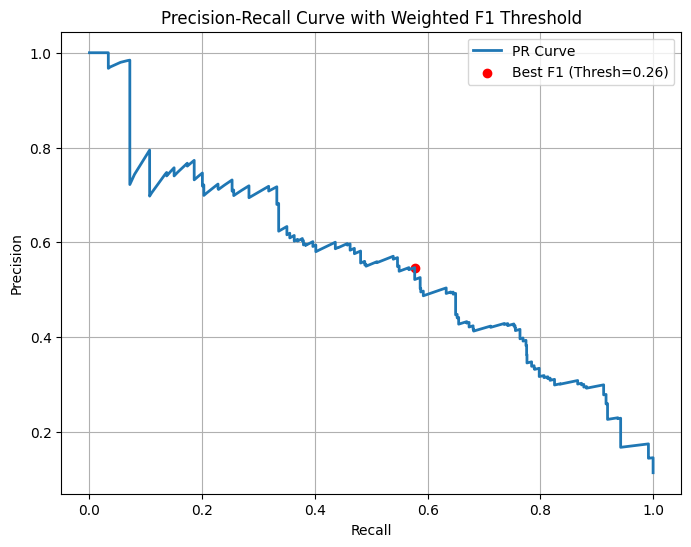

Best threshold: 0.26
F1 at best threshold: 0.561


In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get predicted probabilities for class 1 (FS=1)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute precision-recall using sample weights
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba, sample_weight=weight_test
)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Weighted F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Print best threshold and F1 score
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")

In [63]:
y_pred_custom = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom, sample_weight=weight_test))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94  102413.0
           1       0.55      0.58      0.56   13152.0

    accuracy                           0.90  115565.0
   macro avg       0.75      0.76      0.75  115565.0
weighted avg       0.90      0.90      0.90  115565.0

